# **150 episodes**

=== INFOSYS LSTM Stock Price Predictor (Test Phase June–July 2025) ===
Enter a date (YYYY-MM-DD): 2025-06-18
Fetching data from Yahoo Finance...


[*********************100%***********************]  1 of 1 completed


Streaming output truncated to the last 5000 lines.
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.2981e-05 - val_loss: 0.0013
Epoch 7502/10000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.0165e-05 - val_loss: 0.0015
Epoch 7503/10000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8647e-05 - val_loss: 0.0015
Epoch 7504/10000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.8512e-05 - val_loss: 0.0014
Epoch 7505/10000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 1.6229e-05 - val_loss: 0.0015
Epoch 7506/10000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.0909e-05 - val_loss: 0.0015
Epoch 7507/10000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.7323e-05 - val_loss: 0.0015
Epoch 7508/10000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.0403e-05 - val_loss: 0.0015
Epoch 7509/10000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.1145e-05 - val_loss: 0.0014
Epoch 7510/10000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 3.0175e-05 - val_loss: 0.0012
Epoch 7511/10000

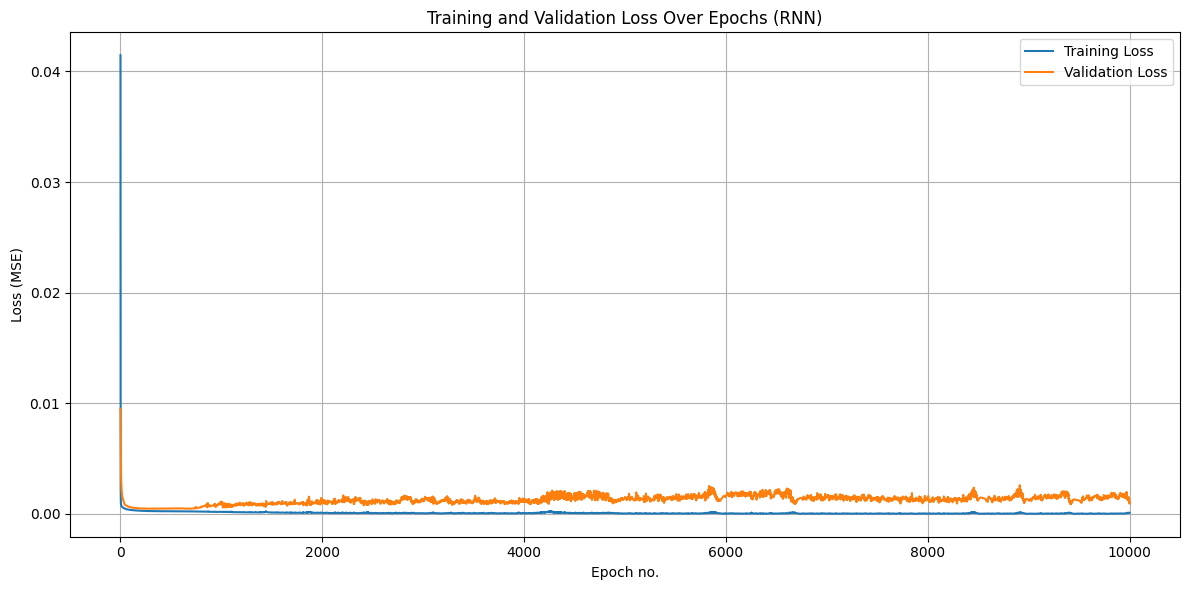


--- Starting Reinforcement Learning Fine-Tuning (Batched) ---
RL Epoch 1/150, Average Loss per Batch: 0.000071
RL Epoch 2/150, Average Loss per Batch: 0.000039
RL Epoch 3/150, Average Loss per Batch: 0.000029
RL Epoch 4/150, Average Loss per Batch: 0.000026
RL Epoch 5/150, Average Loss per Batch: 0.000025
RL Epoch 6/150, Average Loss per Batch: 0.000023
RL Epoch 7/150, Average Loss per Batch: 0.000022
RL Epoch 8/150, Average Loss per Batch: 0.000020
RL Epoch 9/150, Average Loss per Batch: 0.000019
RL Epoch 10/150, Average Loss per Batch: 0.000018
RL Epoch 11/150, Average Loss per Batch: 0.000018
RL Epoch 12/150, Average Loss per Batch: 0.000017
RL Epoch 13/150, Average Loss per Batch: 0.000016
RL Epoch 14/150, Average Loss per Batch: 0.000015
RL Epoch 15/150, Average Loss per Batch: 0.000015
RL Epoch 16/150, Average Loss per Batch: 0.000014
RL Epoch 17/150, Average Loss per Batch: 0.000014
RL Epoch 18/150, Average Loss per Batch: 0.000014
RL Epoch 19/150, Average Loss per Batch: 0.000

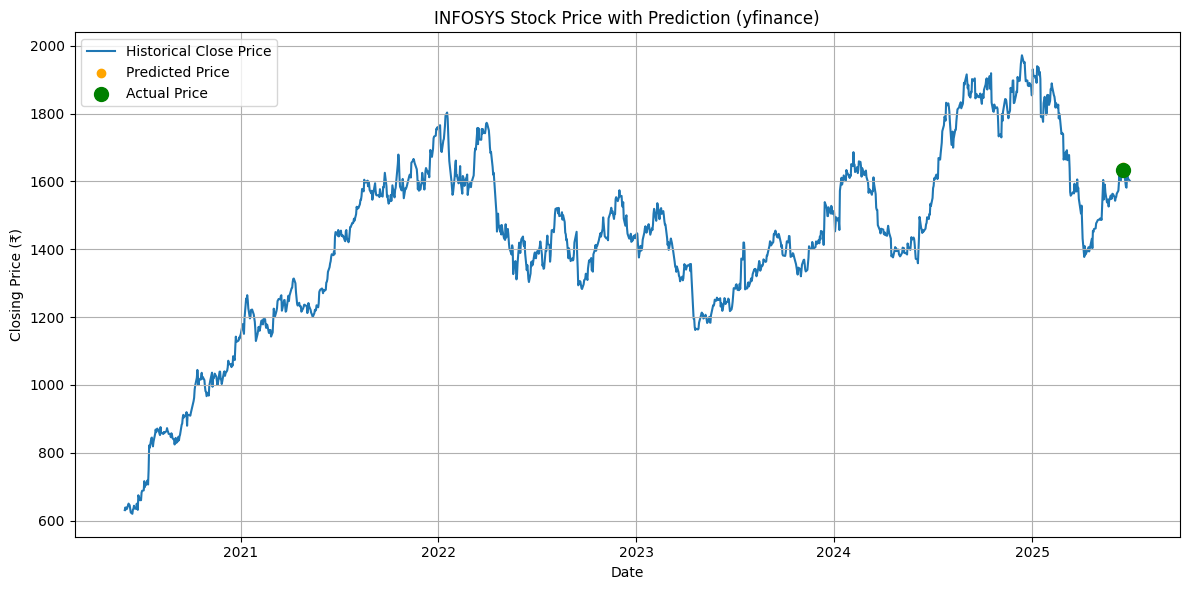


 Test Set Performance Metrics (RNN):
 Mean Absolute Error (MAE) : ₹26.90
 Mean Squared Error (MSE)  : ₹1097.34
 Root Squared Error (RMSE) : ₹33.13
 R² Score                  : -0.2870
 Mean Absolute Percentage Error (MAPE) : 1.68%
 Accuracy (100 - MAPE) : 98.32%
 MSE Percentage of Average Price: 68.75%
 MAE Percentage of Average Price: 1.68%


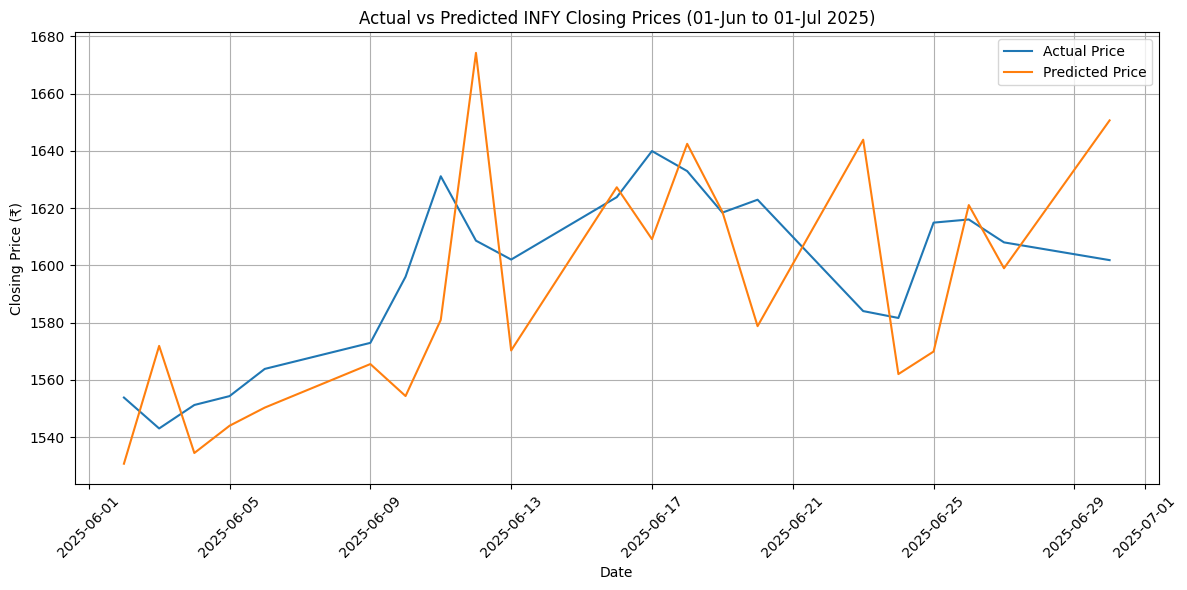

In [1]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from matplotlib.dates import DateFormatter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import numpy as np
import pandas as pd
import datetime
import holidays
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings('ignore')

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

SYMBOL = "INFY.NS"
SEQUENCE_LENGTH = 60

TRAIN_START_DATE = "2020-06-01"
TRAIN_END_DATE = "2025-05-31"

TEST_START_DATE = "2025-06-01"
TEST_END_DATE = "2025-07-01"

# Get Indian trading holidays
def get_nse_holidays():
    in_holidays = holidays.India(years=range(2020, 2026))
    return set(in_holidays.keys())

TRADING_HOLIDAYS = get_nse_holidays()

def is_valid_date(date_str):
    try:
        date = datetime.datetime.strptime(date_str, "%Y-%m-%d").date()
        if not (datetime.date(2025, 6, 1) <= date <= datetime.date(2025, 7, 1)):
            print("Date must be between 2025-06-01 and 2025-07-01.")
            return False
        if date.weekday() >= 5:
            print("Weekends are not trading days.")
            return False
        if date in TRADING_HOLIDAYS:
            print("Entered date is a trading holiday.")
            return False
        return True
    except ValueError:
        print("Invalid date format. Use YYYY-MM-DD.")
        return False

def get_stock_data():
    print("Fetching data from Yahoo Finance...")
    full_df = yf.download(SYMBOL, start=TRAIN_START_DATE, end=TEST_END_DATE)
    full_df = full_df[['Close']]
    full_df.dropna(inplace=True)
    full_df.index = pd.to_datetime(full_df.index)

    train_df = full_df.loc[TRAIN_START_DATE:TRAIN_END_DATE]
    test_df = full_df.loc[TEST_START_DATE:TEST_END_DATE]
    return train_df, test_df, full_df

# Prompt until valid date is entered
def get_user_date():
    while True:
        date_input = input("Enter a date (YYYY-MM-DD): ")
        if is_valid_date(date_input):
            return datetime.datetime.strptime(date_input, "%Y-%m-%d").date()

# Build the SimpleRNN model
def build_model(input_shape, learning_rate=0.001): # Added learning_rate parameter
    model = Sequential()
    model.add(SimpleRNN(units=50, activation='tanh', input_shape=input_shape))
    model.add(Dense(1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) # Use custom learning rate
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Reinforcement Learning Fine-Tuning
class RLAgent:
    """
    A simple RL Agent to fine-tune the RNN model.
    The "environment" is the time series data, and the "action" is the prediction.
    The reward is based on prediction accuracy.
    """
    def __init__(self, model, learning_rate=0.001):
        self.model = model
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) # Pass learning_rate to RLAgent

    @tf.function
    def train_step(self, state, target):
        """
        Performs a single training step to fine-tune the model weights.
        """
        with tf.GradientTape() as tape:
            prediction = self.model(state, training=True)
            # Use Mean Squared Error directly as the loss to minimize
            loss = tf.reduce_mean(tf.square(tf.cast(target, tf.float32) - prediction))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss # Return the mean loss for the batch


def fine_tune_with_rl(model, X_train, y_train, epochs=5, learning_rate=0.001, batch_size=32):
    """
    Fine- tunes the pre-trained RNN model using a simple reinforcement learning loop with batched data.
    """
    print("\n--- Starting Reinforcement Learning Fine-Tuning (Batched) ---")
    agent = RLAgent(model, learning_rate=learning_rate)

    # Create a TensorFlow Dataset and batch it
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    dataset = dataset.batch(batch_size)

    num_batches = tf.data.experimental.cardinality(dataset).numpy()

    for epoch in range(epochs):
        total_loss = 0
        batch_count = 0
        for batch_x, batch_y in dataset:
            # Ensure batch_x has the correct shape (batch_size, sequence_length, 1)
            batch_x_reshaped = tf.reshape(batch_x, (tf.shape(batch_x)[0], tf.shape(batch_x)[1], 1))
            loss = agent.train_step(batch_x_reshaped, batch_y)
            total_loss += loss.numpy() # Sum up the mean loss for each batch
            batch_count += 1

        # Calculate average loss per epoch
        average_epoch_loss = total_loss / num_batches if num_batches > 0 else 0
        print(f"RL Epoch {epoch + 1}/{epochs}, Average Loss per Batch: {average_epoch_loss:.6f}") # Print average loss

    print("--- RL Fine-Tuning Complete ---")
    return model


def create_test_sequences(train_df, test_df, scaler):
    combined = pd.concat([train_df, test_df])
    scaled = scaler.transform(combined[['Close']])
    X_test = []
    test_dates = test_df.index.date

    for i in range(len(train_df), len(combined)):
        if i - SEQUENCE_LENGTH < 0:
            continue
        seq = scaled[i - SEQUENCE_LENGTH:i]
        X_test.append(seq)

    X_test = np.array(X_test)
    return X_test, test_dates

def predict_price_on_test(model, full_df, scaler, user_date):
    all_dates = full_df.index.date
    try:
        idx = list(all_dates).index(user_date)
    except ValueError:
        print("User date not found in data.")
        return None, None, user_date

    if idx < SEQUENCE_LENGTH:
        print("Not enough data to predict for this date.")
        return None, None, user_date

    input_seq = scaler.transform(full_df[['Close']].values)[idx - SEQUENCE_LENGTH:idx]
    input_seq = np.reshape(input_seq, (1, SEQUENCE_LENGTH, 1))

    predicted_scaled = model.predict(input_seq, verbose=0)
    predicted_price = scaler.inverse_transform(predicted_scaled)[0][0]

    actual_price = float(full_df.iloc[idx]['Close']) if idx < len(full_df) else None
    return predicted_price, actual_price, full_df.index[idx].date()

# Plot the result
def plot_results(df, predicted_date, predicted_price, actual_price):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Close'], label='Historical Close Price',zorder=1)
    #plt.axvline(pd.to_datetime(predicted_date), color='red', linestyle='--', label='Predicted Date')
    plt.scatter(pd.to_datetime(predicted_date), predicted_price, color='orange', label='Predicted Price',zorder=2)
    if actual_price is not None:
        plt.scatter(pd.to_datetime(predicted_date), actual_price, color='green', label='Actual Price',zorder=3, s=100)
    plt.title("INFOSYS Stock Price with Prediction (yfinance)")
    plt.xlabel("Date")
    plt.ylabel("Closing Price (₹)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Plotting error with no. of epochs
def plot_training_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Training and Validation Loss Over Epochs (RNN)")
    plt.xlabel("Epoch no.")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    print("=== INFOSYS LSTM Stock Price Predictor (Test Phase June–July 2025) ===")
    user_date = get_user_date()

    # Step 1: Get stock data
    train_df, test_df, full_df = get_stock_data()

    # Step 2: Preprocess
    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(train_df[['Close']])
    X, y = [], []
    for i in range(SEQUENCE_LENGTH, len(scaled_train)):
        X.append(scaled_train[i - SEQUENCE_LENGTH:i])
        y.append(scaled_train[i])
    X = np.array(X)
    y = np.array(y)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
    #early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    # Step 3: Build and train model
    model = build_model((X_train.shape[1], 1), learning_rate=0.0005) # Reduced Adam learning rate
    print("Training RNN model...")
    history = model.fit(X_train, y_train, epochs=10000, batch_size=64, validation_data=(X_val, y_val), verbose = 1) #callbacks = [early_stop], verbose=1)

    #print(f"\nBest weights restored from epoch: {early_stop.best_epoch + 1}")

    # Step 4: Plot training loss
    plot_training_loss(history)

    # Step 5: Fine-tune with Reinforcement Learning
    rl_tuned_model = fine_tune_with_rl(model, X_train, y_train, epochs=150, learning_rate=0.0001, batch_size=32)

    # Predict on training data to evaluate performance
    y_train_pred_scaled = rl_tuned_model.predict(X_train, verbose=0)
    y_train_pred = scaler.inverse_transform(y_train_pred_scaled)
    y_true_train = scaler.inverse_transform(y_train.reshape(-1, 1))

    # Calculate and print training metrics
    mae_train = mean_absolute_error(y_true_train, y_train_pred)
    mse_train = mean_squared_error(y_true_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_true_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_true_train, y_train_pred) * 100
    accuracy_train = 100 - mape_train
    mse_percent_train = (mse_train / np.mean(y_true_train)) * 100 if np.mean(y_true_train) != 0 else np.nan
    mae_percent_train = (mae_train / np.mean(y_true_train)) * 100 if np.mean(y_true_train) != 0 else np.nan
    print("\n Training Set Performance Metrics (RNN):")
    print(f" Mean Absolute Error (MAE) : ₹{mae_train:.2f}")
    print(f" Mean Squared Error (MSE)  : ₹{mse_train:.2f}")
    print(f" Root Squared Error (RMSE) : ₹{rmse_train:.2f}")
    print(f" R² Score                  : {r2_train:.4f}")
    print(f" Mean Absolute Percentage Error (MAPE) : {mape_train:.2f}%")
    print(f" Accuracy (100 - MAPE) : {accuracy_train:.2f}%")
    print(f" MSE Percentage of Average Price : {mse_percent_train:.2f}%")
    print(f" MAE Percentage of Average Price : {mae_percent_train:.2f}%")

    # Predict on validation set
    y_val_pred_scaled = rl_tuned_model.predict(X_val, verbose=0)
    y_val_pred = scaler.inverse_transform(y_val_pred_scaled)
    y_val_true = scaler.inverse_transform(y_val.reshape(-1, 1))

    # Calculate and print validation metrics
    mae_val = mean_absolute_error(y_val_true, y_val_pred)
    mse_val = mean_squared_error(y_val_true, y_val_pred)
    rmse_val = np.sqrt(mse_val)
    r2_val = r2_score(y_val_true, y_val_pred)
    mape_val = mean_absolute_percentage_error(y_val_true, y_val_pred) * 100
    accuracy_val = 100 - mape_val
    mse_percent_val = (mse_val / np.mean(y_val_true)) * 100 if np.mean(y_val_true) != 0 else np.nan
    mae_percent_val = (mae_val / np.mean(y_val_true)) * 100 if np.mean(y_val_true) != 0 else np.nan
    print("\n Validation Set Performance Metrics (RNN):")
    print(f" Mean Absolute Error (MAE) : ₹{mae_val:.2f}")
    print(f" Mean Squared Error (MSE)  : ₹{mse_val:.2f}")
    print(f" Root Squared Error (RMSE) : ₹{rmse_val:.2f}")
    print(f" R² Score                  : {r2_val:.4f}")
    print(f" Mean Absolute Percentage Error (MAPE) : {mape_val:.2f}%")
    print(f" Accuracy (100 - MAPE) : {accuracy_val:.2f}%")
    print(f" MSE Percentage of Average Price: {mse_percent_val:.2f}%")
    print(f" MAE Percentage of Average Price: {mae_percent_val:.2f}%")


    # Step 6: Predict for user-input test date
    predicted_price, actual_price, predicted_date = predict_price_on_test(rl_tuned_model, full_df, scaler, user_date)
    if predicted_price is not None:
        print(f"\n Prediction for {predicted_date}:")
        print(f" Predicted Closing Price: ₹{predicted_price:.2f}")
        if actual_price is not None:
            print(f" Actual Closing Price   : ₹{actual_price}")
        else:
            print("Actual price not available.")

        plot_results(full_df, predicted_date, predicted_price, actual_price)
    else:
        print("❌ Unable to make prediction.")

    # === Step 7: Predict all test dates and compare ===

    # Reuse combined full_df
    combined_df = pd.concat([train_df, test_df])
    scaled_combined = scaler.transform(combined_df[['Close']])

    X_test_all = []
    test_date_indexes = []

    for i in range(len(train_df), len(combined_df)):
        if i - SEQUENCE_LENGTH < 0:
            continue
        seq = scaled_combined[i - SEQUENCE_LENGTH:i]
        X_test_all.append(seq)
        test_date_indexes.append(combined_df.index[i])

    X_test_all = np.array(X_test_all)

    # Predict on test sequences
    y_test_pred_scaled = rl_tuned_model.predict(X_test_all, verbose=0)
    y_test_pred = scaler.inverse_transform(y_test_pred_scaled)

    # Actual prices
    y_test_true = test_df.loc[test_date_indexes, 'Close'].values

    # Calculate and print test metrics
    mae_test = mean_absolute_error(y_test_true, y_test_pred)
    mse_test = mean_squared_error(y_test_true, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test_true, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_true, y_test_pred) * 100
    accuracy_test = 100 - mape_test
    mse_percent_test = (mse_test / np.mean(y_test_true)) * 100 if np.mean(y_test_true) != 0 else np.nan
    mae_percent_test = (mae_test / np.mean(y_test_true)) * 100 if np.mean(y_test_true) != 0 else np.nan
    print("\n Test Set Performance Metrics (RNN):")
    print(f" Mean Absolute Error (MAE) : ₹{mae_test:.2f}")
    print(f" Mean Squared Error (MSE)  : ₹{mse_test:.2f}")
    print(f" Root Squared Error (RMSE) : ₹{rmse_test:.2f}")
    print(f" R² Score                  : {r2_test:.4f}")
    print(f" Mean Absolute Percentage Error (MAPE) : {mape_test:.2f}%")
    print(f" Accuracy (100 - MAPE) : {accuracy_test:.2f}%")
    print(f" MSE Percentage of Average Price: {mse_percent_test:.2f}%")
    print(f" MAE Percentage of Average Price: {mae_percent_test:.2f}%")

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(test_date_indexes, y_test_true, label='Actual Price')
    plt.plot(test_date_indexes, y_test_pred, label='Predicted Price')
    plt.title("Actual vs Predicted INFY Closing Prices (01-Jun to 01-Jul 2025)")
    plt.xlabel("Date")
    plt.ylabel("Closing Price (₹)")
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()

# **200 episodes**

=== INFOSYS LSTM Stock Price Predictor (Test Phase June–July 2025) ===
Enter a date (YYYY-MM-DD): 2025-06-18


[*********************100%***********************]  1 of 1 completed

Fetching data from Yahoo Finance...
Training RNN model...
Epoch 1/10000


Streaming output truncated to the last 5000 lines.
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.8096e-05 - val_loss: 8.9374e-04
Epoch 7502/10000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1.7490e-05 - val_loss: 9.2460e-04
Epoch 7503/10000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.1493e-05 - val_loss: 9.2703e-04
Epoch 7504/10000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.4834e-05 - val_loss: 9.4891e-04
Epoch 7505/10000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.5925e-05 - val_loss: 9.7866e-04
Epoch 7506/10000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 2.7198e-05 - val_loss: 0.0010
Epoch 7507/10000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 2.9645e-05 - val_loss: 0.0011
Epoch 7508/10000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 3.0537e-05 - val_loss: 0.0012
Epoch 7509/10000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.7043e-05 - val_loss: 0.0012
Epoch 7510/10000
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 2.3043e-05 - val_loss: 0.0

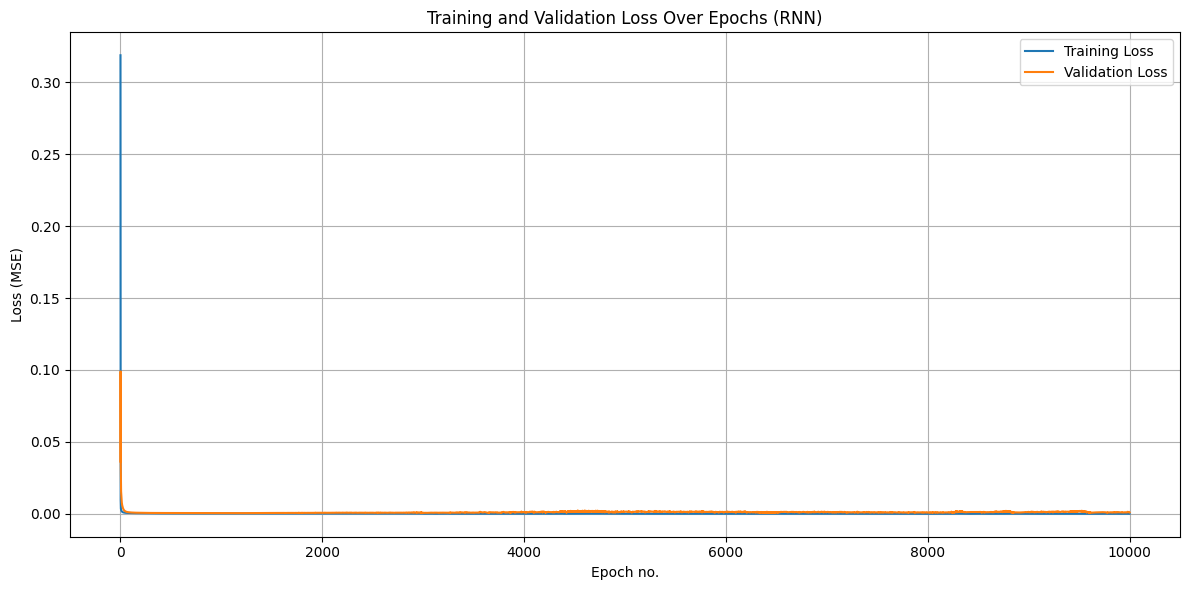


--- Starting Reinforcement Learning Fine-Tuning (Batched) ---
RL Epoch 1/200, Average Loss per Batch: 0.000018
RL Epoch 2/200, Average Loss per Batch: 0.000018
RL Epoch 3/200, Average Loss per Batch: 0.000013
RL Epoch 4/200, Average Loss per Batch: 0.000023
RL Epoch 5/200, Average Loss per Batch: 0.000015
RL Epoch 6/200, Average Loss per Batch: 0.000010
RL Epoch 7/200, Average Loss per Batch: 0.000006
RL Epoch 8/200, Average Loss per Batch: 0.000006
RL Epoch 9/200, Average Loss per Batch: 0.000005
RL Epoch 10/200, Average Loss per Batch: 0.000005
RL Epoch 11/200, Average Loss per Batch: 0.000007
RL Epoch 12/200, Average Loss per Batch: 0.000010
RL Epoch 13/200, Average Loss per Batch: 0.000022
RL Epoch 14/200, Average Loss per Batch: 0.000032
RL Epoch 15/200, Average Loss per Batch: 0.000032
RL Epoch 16/200, Average Loss per Batch: 0.000018
RL Epoch 17/200, Average Loss per Batch: 0.000009
RL Epoch 18/200, Average Loss per Batch: 0.000006
RL Epoch 19/200, Average Loss per Batch: 0.000

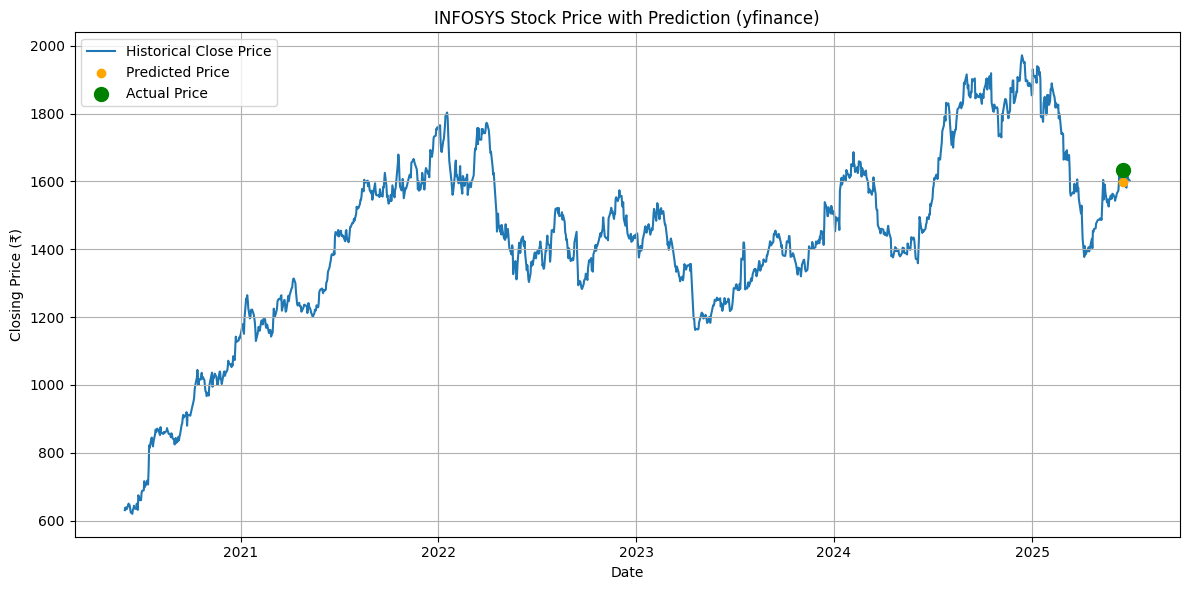


 Test Set Performance Metrics (RNN):
 Mean Absolute Error (MAE) : ₹34.29
 Mean Squared Error (MSE)  : ₹1630.87
 Root Squared Error (RMSE) : ₹40.38
 R² Score                  : -0.9128
 Mean Absolute Percentage Error (MAPE) : 2.14%
 Accuracy (100 - MAPE) : 97.86%
 MSE Percentage of Average Price: 102.17%
 MAE Percentage of Average Price: 2.15%


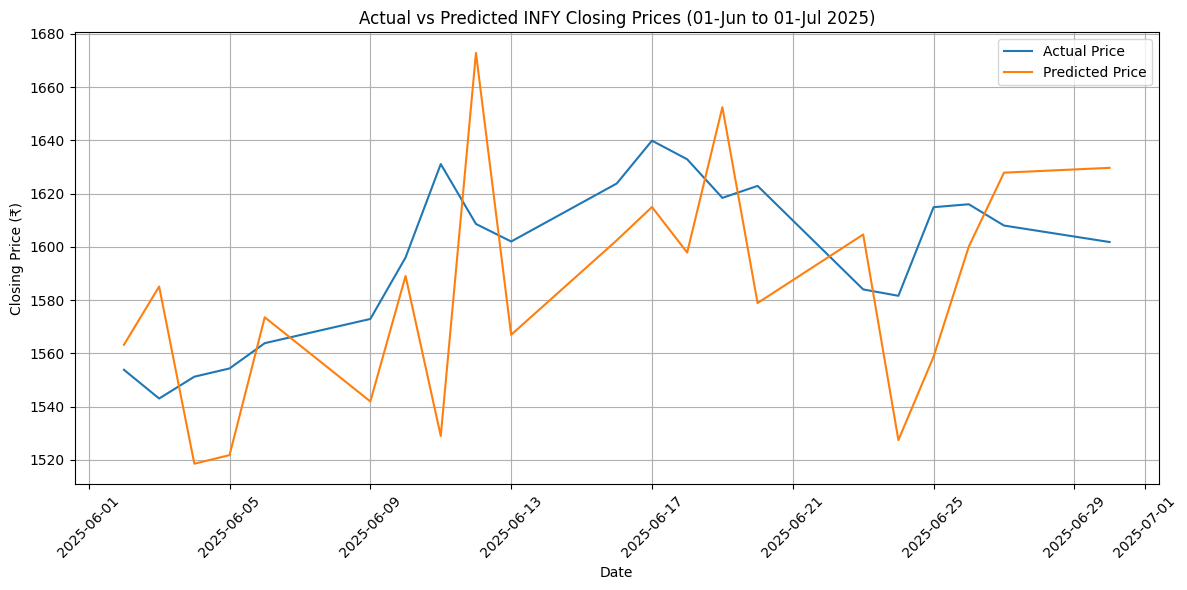

In [2]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import SimpleRNN
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from matplotlib.dates import DateFormatter
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
import numpy as np
import pandas as pd
import datetime
import holidays
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings

warnings.filterwarnings('ignore')

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

SYMBOL = "INFY.NS"
SEQUENCE_LENGTH = 60

TRAIN_START_DATE = "2020-06-01"
TRAIN_END_DATE = "2025-05-31"

TEST_START_DATE = "2025-06-01"
TEST_END_DATE = "2025-07-01"

# Get Indian trading holidays
def get_nse_holidays():
    in_holidays = holidays.India(years=range(2020, 2026))
    return set(in_holidays.keys())

TRADING_HOLIDAYS = get_nse_holidays()

def is_valid_date(date_str):
    try:
        date = datetime.datetime.strptime(date_str, "%Y-%m-%d").date()
        if not (datetime.date(2025, 6, 1) <= date <= datetime.date(2025, 7, 1)):
            print("Date must be between 2025-06-01 and 2025-07-01.")
            return False
        if date.weekday() >= 5:
            print("Weekends are not trading days.")
            return False
        if date in TRADING_HOLIDAYS:
            print("Entered date is a trading holiday.")
            return False
        return True
    except ValueError:
        print("Invalid date format. Use YYYY-MM-DD.")
        return False

def get_stock_data():
    print("Fetching data from Yahoo Finance...")
    full_df = yf.download(SYMBOL, start=TRAIN_START_DATE, end=TEST_END_DATE)
    full_df = full_df[['Close']]
    full_df.dropna(inplace=True)
    full_df.index = pd.to_datetime(full_df.index)

    train_df = full_df.loc[TRAIN_START_DATE:TRAIN_END_DATE]
    test_df = full_df.loc[TEST_START_DATE:TEST_END_DATE]
    return train_df, test_df, full_df

# Prompt until valid date is entered
def get_user_date():
    while True:
        date_input = input("Enter a date (YYYY-MM-DD): ")
        if is_valid_date(date_input):
            return datetime.datetime.strptime(date_input, "%Y-%m-%d").date()

# Build the SimpleRNN model
def build_model(input_shape, learning_rate=0.001): # Added learning_rate parameter
    model = Sequential()
    model.add(SimpleRNN(units=50, activation='tanh', input_shape=input_shape))
    model.add(Dense(1))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) # Use custom learning rate
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

# Reinforcement Learning Fine-Tuning
class RLAgent:
    """
    A simple RL Agent to fine-tune the RNN model.
    The "environment" is the time series data, and the "action" is the prediction.
    The reward is based on prediction accuracy.
    """
    def __init__(self, model, learning_rate=0.001):
        self.model = model
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate) # Pass learning_rate to RLAgent

    @tf.function
    def train_step(self, state, target):
        """
        Performs a single training step to fine-tune the model weights.
        """
        with tf.GradientTape() as tape:
            prediction = self.model(state, training=True)
            # Use Mean Squared Error directly as the loss to minimize
            loss = tf.reduce_mean(tf.square(tf.cast(target, tf.float32) - prediction))

        grads = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))
        return loss # Return the mean loss for the batch


def fine_tune_with_rl(model, X_train, y_train, epochs=5, learning_rate=0.001, batch_size=32):
    """
    Fine- tunes the pre-trained RNN model using a simple reinforcement learning loop with batched data.
    """
    print("\n--- Starting Reinforcement Learning Fine-Tuning (Batched) ---")
    agent = RLAgent(model, learning_rate=learning_rate)

    # Create a TensorFlow Dataset and batch it
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    dataset = dataset.batch(batch_size)

    num_batches = tf.data.experimental.cardinality(dataset).numpy()

    for epoch in range(epochs):
        total_loss = 0
        batch_count = 0
        for batch_x, batch_y in dataset:
            # Ensure batch_x has the correct shape (batch_size, sequence_length, 1)
            batch_x_reshaped = tf.reshape(batch_x, (tf.shape(batch_x)[0], tf.shape(batch_x)[1], 1))
            loss = agent.train_step(batch_x_reshaped, batch_y)
            total_loss += loss.numpy() # Sum up the mean loss for each batch
            batch_count += 1

        # Calculate average loss per epoch
        average_epoch_loss = total_loss / num_batches if num_batches > 0 else 0
        print(f"RL Epoch {epoch + 1}/{epochs}, Average Loss per Batch: {average_epoch_loss:.6f}") # Print average loss

    print("--- RL Fine-Tuning Complete ---")
    return model


def create_test_sequences(train_df, test_df, scaler):
    combined = pd.concat([train_df, test_df])
    scaled = scaler.transform(combined[['Close']])
    X_test = []
    test_dates = test_df.index.date

    for i in range(len(train_df), len(combined)):
        if i - SEQUENCE_LENGTH < 0:
            continue
        seq = scaled[i - SEQUENCE_LENGTH:i]
        X_test.append(seq)

    X_test = np.array(X_test)
    return X_test, test_dates

def predict_price_on_test(model, full_df, scaler, user_date):
    all_dates = full_df.index.date
    try:
        idx = list(all_dates).index(user_date)
    except ValueError:
        print("User date not found in data.")
        return None, None, user_date

    if idx < SEQUENCE_LENGTH:
        print("Not enough data to predict for this date.")
        return None, None, user_date

    input_seq = scaler.transform(full_df[['Close']].values)[idx - SEQUENCE_LENGTH:idx]
    input_seq = np.reshape(input_seq, (1, SEQUENCE_LENGTH, 1))

    predicted_scaled = model.predict(input_seq, verbose=0)
    predicted_price = scaler.inverse_transform(predicted_scaled)[0][0]

    actual_price = float(full_df.iloc[idx]['Close']) if idx < len(full_df) else None
    return predicted_price, actual_price, full_df.index[idx].date()

# Plot the result
def plot_results(df, predicted_date, predicted_price, actual_price):
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Close'], label='Historical Close Price',zorder=1)
    #plt.axvline(pd.to_datetime(predicted_date), color='red', linestyle='--', label='Predicted Date')
    plt.scatter(pd.to_datetime(predicted_date), predicted_price, color='orange', label='Predicted Price',zorder=2)
    if actual_price is not None:
        plt.scatter(pd.to_datetime(predicted_date), actual_price, color='green', label='Actual Price',zorder=3, s=100)
    plt.title("INFOSYS Stock Price with Prediction (yfinance)")
    plt.xlabel("Date")
    plt.ylabel("Closing Price (₹)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

#Plotting error with no. of epochs
def plot_training_loss(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title("Training and Validation Loss Over Epochs (RNN)")
    plt.xlabel("Epoch no.")
    plt.ylabel("Loss (MSE)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    print("=== INFOSYS LSTM Stock Price Predictor (Test Phase June–July 2025) ===")
    user_date = get_user_date()

    # Step 1: Get stock data
    train_df, test_df, full_df = get_stock_data()

    # Step 2: Preprocess
    scaler = MinMaxScaler()
    scaled_train = scaler.fit_transform(train_df[['Close']])
    X, y = [], []
    for i in range(SEQUENCE_LENGTH, len(scaled_train)):
        X.append(scaled_train[i - SEQUENCE_LENGTH:i])
        y.append(scaled_train[i])
    X = np.array(X)
    y = np.array(y)

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
    #early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
    # Step 3: Build and train model
    model = build_model((X_train.shape[1], 1), learning_rate=0.0005) # Reduced Adam learning rate
    print("Training RNN model...")
    history = model.fit(X_train, y_train, epochs=10000, batch_size=64, validation_data=(X_val, y_val), verbose = 1) #callbacks = [early_stop], verbose=1)

    #print(f"\nBest weights restored from epoch: {early_stop.best_epoch + 1}")

    # Step 4: Plot training loss
    plot_training_loss(history)

    # Step 5: Fine-tune with Reinforcement Learning
    rl_tuned_model = fine_tune_with_rl(model, X_train, y_train, epochs=200, learning_rate=0.0001, batch_size=32)

    # Predict on training data to evaluate performance
    y_train_pred_scaled = rl_tuned_model.predict(X_train, verbose=0)
    y_train_pred = scaler.inverse_transform(y_train_pred_scaled)
    y_true_train = scaler.inverse_transform(y_train.reshape(-1, 1))

    # Calculate and print training metrics
    mae_train = mean_absolute_error(y_true_train, y_train_pred)
    mse_train = mean_squared_error(y_true_train, y_train_pred)
    rmse_train = np.sqrt(mse_train)
    r2_train = r2_score(y_true_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_true_train, y_train_pred) * 100
    accuracy_train = 100 - mape_train
    mse_percent_train = (mse_train / np.mean(y_true_train)) * 100 if np.mean(y_true_train) != 0 else np.nan
    mae_percent_train = (mae_train / np.mean(y_true_train)) * 100 if np.mean(y_true_train) != 0 else np.nan
    print("\n Training Set Performance Metrics (RNN):")
    print(f" Mean Absolute Error (MAE) : ₹{mae_train:.2f}")
    print(f" Mean Squared Error (MSE)  : ₹{mse_train:.2f}")
    print(f" Root Squared Error (RMSE) : ₹{rmse_train:.2f}")
    print(f" R² Score                  : {r2_train:.4f}")
    print(f" Mean Absolute Percentage Error (MAPE) : {mape_train:.2f}%")
    print(f" Accuracy (100 - MAPE) : {accuracy_train:.2f}%")
    print(f" MSE Percentage of Average Price : {mse_percent_train:.2f}%")
    print(f" MAE Percentage of Average Price : {mae_percent_train:.2f}%")

    # Predict on validation set
    y_val_pred_scaled = rl_tuned_model.predict(X_val, verbose=0)
    y_val_pred = scaler.inverse_transform(y_val_pred_scaled)
    y_val_true = scaler.inverse_transform(y_val.reshape(-1, 1))

    # Calculate and print validation metrics
    mae_val = mean_absolute_error(y_val_true, y_val_pred)
    mse_val = mean_squared_error(y_val_true, y_val_pred)
    rmse_val = np.sqrt(mse_val)
    r2_val = r2_score(y_val_true, y_val_pred)
    mape_val = mean_absolute_percentage_error(y_val_true, y_val_pred) * 100
    accuracy_val = 100 - mape_val
    mse_percent_val = (mse_val / np.mean(y_val_true)) * 100 if np.mean(y_val_true) != 0 else np.nan
    mae_percent_val = (mae_val / np.mean(y_val_true)) * 100 if np.mean(y_val_true) != 0 else np.nan
    print("\n Validation Set Performance Metrics (RNN):")
    print(f" Mean Absolute Error (MAE) : ₹{mae_val:.2f}")
    print(f" Mean Squared Error (MSE)  : ₹{mse_val:.2f}")
    print(f" Root Squared Error (RMSE) : ₹{rmse_val:.2f}")
    print(f" R² Score                  : {r2_val:.4f}")
    print(f" Mean Absolute Percentage Error (MAPE) : {mape_val:.2f}%")
    print(f" Accuracy (100 - MAPE) : {accuracy_val:.2f}%")
    print(f" MSE Percentage of Average Price: {mse_percent_val:.2f}%")
    print(f" MAE Percentage of Average Price: {mae_percent_val:.2f}%")


    # Step 6: Predict for user-input test date
    predicted_price, actual_price, predicted_date = predict_price_on_test(rl_tuned_model, full_df, scaler, user_date)
    if predicted_price is not None:
        print(f"\n Prediction for {predicted_date}:")
        print(f" Predicted Closing Price: ₹{predicted_price:.2f}")
        if actual_price is not None:
            print(f" Actual Closing Price   : ₹{actual_price}")
        else:
            print("Actual price not available.")

        plot_results(full_df, predicted_date, predicted_price, actual_price)
    else:
        print("❌ Unable to make prediction.")

    # === Step 7: Predict all test dates and compare ===

    # Reuse combined full_df
    combined_df = pd.concat([train_df, test_df])
    scaled_combined = scaler.transform(combined_df[['Close']])

    X_test_all = []
    test_date_indexes = []

    for i in range(len(train_df), len(combined_df)):
        if i - SEQUENCE_LENGTH < 0:
            continue
        seq = scaled_combined[i - SEQUENCE_LENGTH:i]
        X_test_all.append(seq)
        test_date_indexes.append(combined_df.index[i])

    X_test_all = np.array(X_test_all)

    # Predict on test sequences
    y_test_pred_scaled = rl_tuned_model.predict(X_test_all, verbose=0)
    y_test_pred = scaler.inverse_transform(y_test_pred_scaled)

    # Actual prices
    y_test_true = test_df.loc[test_date_indexes, 'Close'].values

    # Calculate and print test metrics
    mae_test = mean_absolute_error(y_test_true, y_test_pred)
    mse_test = mean_squared_error(y_test_true, y_test_pred)
    rmse_test = np.sqrt(mse_test)
    r2_test = r2_score(y_test_true, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test_true, y_test_pred) * 100
    accuracy_test = 100 - mape_test
    mse_percent_test = (mse_test / np.mean(y_test_true)) * 100 if np.mean(y_test_true) != 0 else np.nan
    mae_percent_test = (mae_test / np.mean(y_test_true)) * 100 if np.mean(y_test_true) != 0 else np.nan
    print("\n Test Set Performance Metrics (RNN):")
    print(f" Mean Absolute Error (MAE) : ₹{mae_test:.2f}")
    print(f" Mean Squared Error (MSE)  : ₹{mse_test:.2f}")
    print(f" Root Squared Error (RMSE) : ₹{rmse_test:.2f}")
    print(f" R² Score                  : {r2_test:.4f}")
    print(f" Mean Absolute Percentage Error (MAPE) : {mape_test:.2f}%")
    print(f" Accuracy (100 - MAPE) : {accuracy_test:.2f}%")
    print(f" MSE Percentage of Average Price: {mse_percent_test:.2f}%")
    print(f" MAE Percentage of Average Price: {mae_percent_test:.2f}%")

    # Plot actual vs predicted
    plt.figure(figsize=(12, 6))
    plt.plot(test_date_indexes, y_test_true, label='Actual Price')
    plt.plot(test_date_indexes, y_test_pred, label='Predicted Price')
    plt.title("Actual vs Predicted INFY Closing Prices (01-Jun to 01-Jul 2025)")
    plt.xlabel("Date")
    plt.ylabel("Closing Price (₹)")
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()